In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# **데이터 구하기**
---
어떤 사람들이 생존할 가능성이 높은지를 예측하는 모델훈련을 위한 데이터 다운로드 및 적재

# **데이터 다운로드**

In [46]:
train = pd.read_csv('/kaggle/input/titanic/train.csv') # 훈련셋
test = pd.read_csv('/kaggle/input/titanic/test.csv') # 테스트셋

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

def pie_chart(feature):
    feature_ratio = train[feature].value_counts(sort=False)
    feature_size = feature_ratio.size
    feature_index = feature_ratio.index
    survived = train[train['Survived'] == 1][feature].value_counts() # 생존자수
    dead = train[train['Survived'] == 0][feature].value_counts() # 사망자수

    plt.plot(aspect='auto')
    plt.pie(feature_ratio, labels=feature_index, autopct='%1.1f%%')
    plt.title(feature + '\'s ratio in total')
    plt.show()
    
    if(feature != 'Survived'):
        for i, index in enumerate(feature_index):
            plt.subplot(1, feature_size + 1, i + 1, aspect='equal')
            plt.pie([survived[index], dead[index]], labels=['Survived', 'Dead'], autopct='%1.1f%%')
            plt.title(str(index) + '\'s ratio')
    
        plt.show()
        
def bar_chart(feature):
    survived = train[train['Survived'] == 1][feature].value_counts()
    dead = train[train['Survived'] == 0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind='bar', figsize=(10, 5))

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [49]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

`Age`, `Cabin`, `Embarked` 속성에 결측치가 있음을 확인했다.
특히, `Cabin`은 결측치의 비율이 전체의 77%이므로 일단 무시하는것으로 한다. 
`Age`의 경우 중간값으로 결측치를 채우는 것으로 한다.
`Name`과 `Ticket` 속성은 모델이 사용할 수 있는 유용한 숫자로 변환하기 어렵기 때문에 이 특성 또한 무시한다.

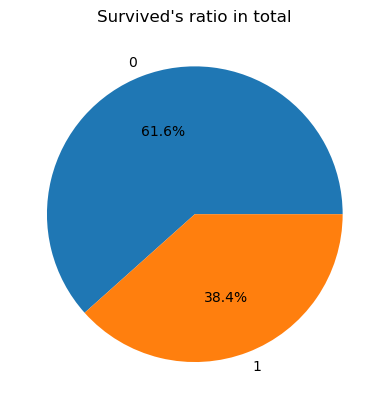

In [50]:
# 생존자 비율
pie_chart('Survived')

60% 정도의 탑승객이 사망했다.

### **범주형 특성**

* Sex
* Pclass
* Embarked

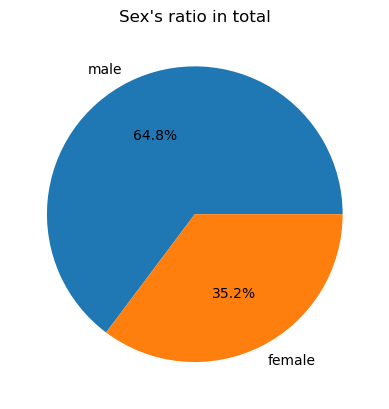

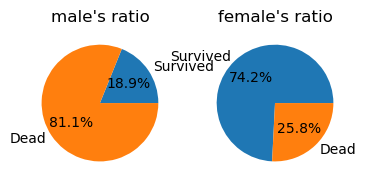

In [51]:
# 성별
pie_chart('Sex')

`male`이 `female`보다 많이 탑승했고, 사망자 비율은 `male`의 비율이 더 높다.

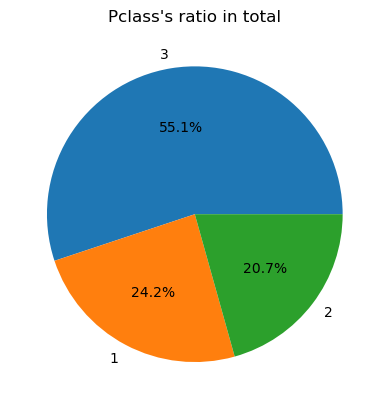

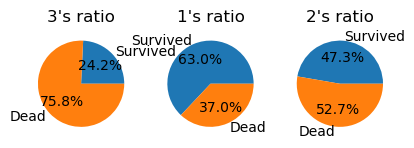

In [52]:
# 티켓 등급
pie_chart('Pclass')

타이타닉 호에 탑승한 사람 중 

티켓 등급이 가장 낮은 사람들이 55% 정도로 가장 많았으며, 티켓 등급이 1인 사람들이 그 다음으로 많았고 2인 사람들이 가장 적었다. 

티켓 등급이 높을수록(숫자가 작을수록) 생존 비율이 높다는 것을 알 수 있다.

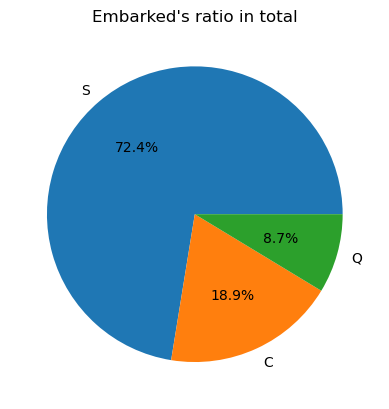

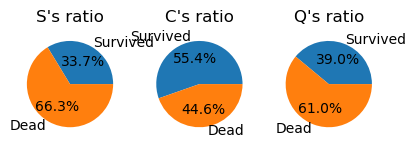

In [53]:
# 탑승 항구
pie_chart('Embarked')

Southampton, Cherbourg, Queenstown 순으로 탑승한 사람이 많았으며, Cherbourg을 제외한 다른 두 항구에서 탑승한 사람들은 사망자 비율이 생존자 비율보다 높았다.

### **수치형 특성**

* SibSp
* Parch

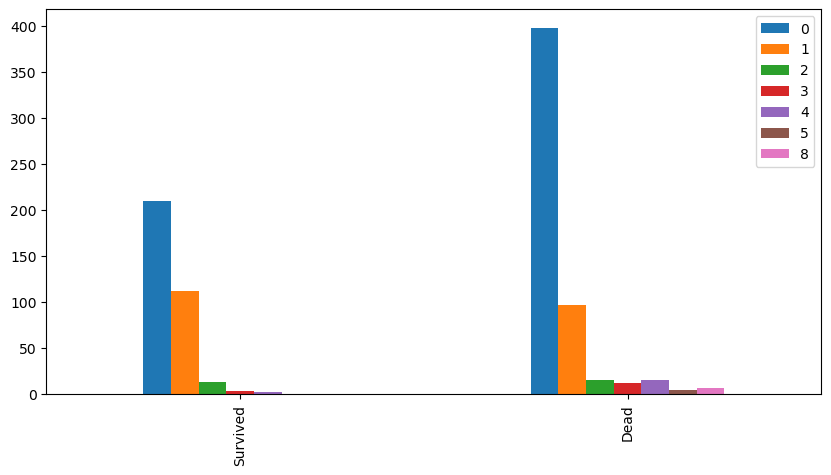

In [54]:
# 함께 탑승한 형제자매, 배우자의 수
bar_chart('SibSp')

생존자 중에서는 혼자 탑승한 사람의 수가 가장 많다. 하지만, 혼자 탑승한 사람의 사망자 대비 생존자의 비율은 매우 낮은 것을 알 수 있다.

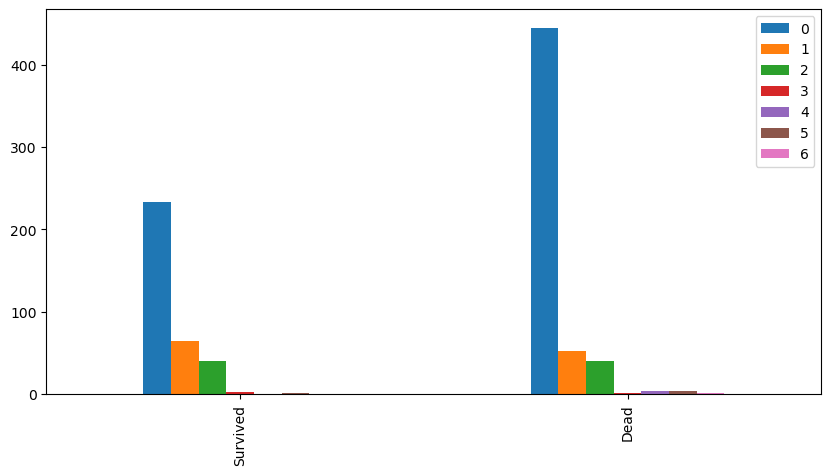

In [55]:
# 함께 탑승한 부모, 자식의 수
bar_chart('Parch')

`Parch` 특성은 `Sibsp`와 비슷한 비율을 보인다.

# **데이터 전처리**

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# 수치형 데이터 파이프라인
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), # 결측치 중간값으로 채움
    ("scaler", StandardScaler()) # 표준화
])

# 범주형 데이터 파이프라인
cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")), # 결측치 최빈값으로 채움
    ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

In [57]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"] # 수치형 특성
cat_attribs = ["Pclass", "Sex", "Embarked"] # 범주형 특성

# 특성별 파이프라인 지정
preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [58]:
X_train = preprocess_pipeline.fit_transform(train)
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [59]:
y_train = train["Survived"] # label

# **모델 선택 및 훈련**

## **랜덤 포레스트 분류**

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [61]:
# 테스트셋 예측
X_test = preprocess_pipeline.transform(test)
y_pred = forest_clf.predict(X_test)

In [62]:
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8092759051186016

## **SVC모델**

In [63]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

SVC모델이 0.82로 랜덤포레스트 모델보다 수치가 더 높아 성능이 좋다는 것을 알 수 있다.

그러나 10겹 교차 검증의 평균 정확도만 보는 것이 아니라, 각 모델에 대한 10개의 점수를 모두 표시하고, 하위 사분위와 상위 사분위를 강조하는 상자 그림과 점수의 범위를 보여주는 "수염"을 표시해보자. `boxplot()` 함수는 이상치(fliers)를 탐지하고 수염에 포함하지 않는다. 특히, 하위 사분위가 $Q_1$이고 상위 사분위가 $Q_3$이면 사분위간 범위(상자높이) $IQR=Q_3-Q_1$ 이고 $Q_1-1.5*IQR$보다 낮은 점수는 이상치이며 $Q_3+1.5*IQR$보다 큰 점수도 이상치이다.

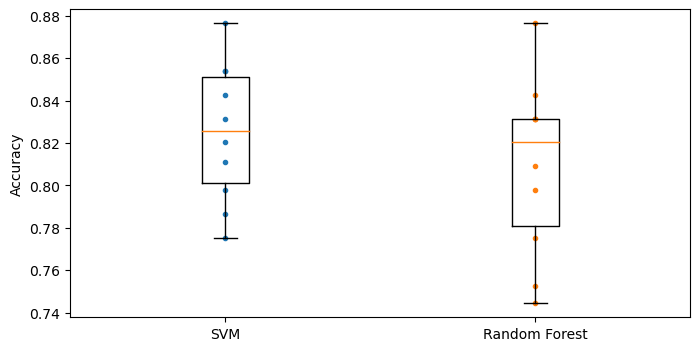

In [64]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

랜덤포레스트 분류기는 전반적으로 평균점수가 낮고 격차도 크기에 SVC가 더 적합할 가능성이 높아보인다.

# **성능 향상**

이 결과를 개선하기 위해서 다음과 같이 할 수 있다.

* 교차 검증 및 그리드 탐색을 사용하여 더 많은 모델을 비교하고 하이퍼 파라미터 조정
* 다음과 같이 특성 엔지니어링을 추가로 실행
    * 수치 속성을 범주형 속성으로 변환
        * ex) 연령 그룹마다 생존율이 매우 다르므로 연령 버킷 범주를 만들고 나이 대신 사용
    * `SibSp`와 `Parch`를 그들의 합으로 대체
    * `Survived` 속성과 잘 상관되는 이름 부분 식별
    * `Cabin`열 사용
        * ex) 첫 번째 문자를 이용하여 범주형 속성으로 처리

In [65]:
train2 = pd.read_csv('/kaggle/input/titanic/train.csv') # 훈련셋
test2 = pd.read_csv('/kaggle/input/titanic/test.csv') # 테스트셋

**수치 속성을 범주형 속성으로 바꾼다**

In [66]:
train2["AgeBucket"] = train2["Age"] // 15 * 15    # 15 단위로 연령 그룹 생성
train2[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()    # 그룸별 데이터 집계

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [67]:
test2["AgeBucket"] = test2["Age"] // 15 * 15    # 15 단위로 연령 그룹 생성

In [68]:
train2["Family"] = train2["SibSp"] + train2["Parch"]
train2[["Family", "Survived"]].groupby(['Family']).mean()

,Survived
Family,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [69]:
test2["Family"] = test2["SibSp"] + test2["Parch"]

---

**Survived 속성과 잘 상관되는 이름 부분 식별**

In [70]:
train2['Title'] = train2.Name.str.extract(' ([A-Za-z]+)\.')    # 공백으로 시작하고 . 으로 끝나느 문자열 추출
    
pd.crosstab(train2['Title'], train2['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


여기서 흔하지 않은 Title은 Other로 대체하고 중복되는 표현을 합친다.

In [71]:
train2['Title'] = train2['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                           'Dona', 'Dr', 'Jonkheer','Lady',
                                           'Major', 'Rev', 'Sir'], 'Other')
train2['Title'] = train2['Title'].replace('Mlle', 'Miss')
train2['Title'] = train2['Title'].replace('Mme', 'Mrs')
train2['Title'] = train2['Title'].replace('Ms', 'Miss')

train2[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


In [72]:
# 추출한 Title 데이터를 학습하기 알맞게 String으로 변형
train2['Title'] = train2['Title'].astype(str)

In [73]:
test2['Title'] = test2.Name.str.extract(' ([A-Za-z]+)\.') 

test2['Title'] = test2['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                           'Dona', 'Dr', 'Jonkheer','Lady',
                                           'Major', 'Rev', 'Sir'], 'Other')
test2['Title'] = test2['Title'].replace('Mlle', 'Miss')
test2['Title'] = test2['Title'].replace('Mme', 'Mrs')
test2['Title'] = test2['Title'].replace('Ms', 'Miss')

test2['Title'] = test2['Title'].astype(str)

---

**전처리**

In [74]:
num_attribs2 = ["Family", "Fare"] # 수치형 특성
cat_attribs2 = ["AgeBucket", "Pclass", "Sex", "Embarked", "Title"] # 범주형 특성

# 특성별 파이프라인 지정
preprocess_pipeline2 = ColumnTransformer([
    ("num", num_pipeline, num_attribs2),
    ("cat", cat_pipeline, cat_attribs2),
])

In [75]:
X_train2 = preprocess_pipeline2.fit_transform(train2)
X_train2

array([[ 0.05915988, -0.50244517,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.05915988,  0.78684529,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.56097483, -0.48885426,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.29942929, -0.17626324,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.56097483, -0.04438104,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.56097483, -0.49237783,  0.        , ...,  1.        ,
         0.        ,  0.        ]])

In [76]:
y_train2 = train2["Survived"] # label

---


**모델 훈련**

* 랜덤 포레스트

In [77]:
X_test2 = preprocess_pipeline2.transform(test2)

In [78]:
forest_scores2 = cross_val_score(forest_clf, X_train2, y_train2, cv=10)
forest_scores2.mean()

0.809250936329588

* SVC

In [79]:
svm_clf.fit(X_train2, y_train2)

SVC(gamma='auto')

In [80]:
svm_pred = svm_clf.predict(X_test2)

In [81]:
svm_scores2 = cross_val_score(svm_clf, X_train2, y_train2, cv=10)
svm_scores2.mean()

0.8361423220973784

변형한 데이터셋에 대한 SVC 모델의 훈련 성능이 증가한 것을 알 수 있다.

In [82]:
submission = pd.DataFrame({
     "PassengerId": test2["PassengerId"],
     "Survived": svm_pred
})

submission.to_csv('submission_svc.csv', index=False)